# Final Project: Numerical Analysis:
# Not-A-Knot Cubic Spline Interpolation
## Walter Hennings

## Background:


Spline interpolation is a form of interpolation in which the interpolant is a piecewise polynomial.
In the cubic spline, these splines are piecewise cubic, meaning degree at most 3.

These polynomials are fit smoothly together, unlike linear splines which just connect the points such that the interpolant is non-differentiable at the data points it is approximating. This leads to a lower interpolating error.

Cubic splines are also preferable to higher order interpolants, as higher order interpolants introduce continuity at higher order derivatives, which may cause overfitting and high frequency behavior in between points known as the Runge Phenomenon.

## Properties:

The cubic spline $S(x)$ is a piecewise function that approximates the data points $(x_1,y_1),...,(x_n,y_n)$ such that each polynomial $S_1,S_2,...,S_n$ is defined on $\{[x_1,x_2],[x_2,x_3],...,[x_{n-1},x_n]\}$. So, $S(x)$ is defined by

$$
S(x) = \left\{
        \begin{array}{ll}
            y_1 + b_1(x-x_1) + c_1(x-x_1)^2 + d_1(x-x_1)^3 & \quad x_1 \leq x \leq x_2 \\
            y_2 + b_2(x-x_2) + c_2(x-x_2)^2 + d_2(x-x_2)^3 & \quad x_2 \leq x \leq x_3 \\
            ...\\
            y_{n-1} + b_{n-1}(x-x_{n-1}) + c_{n-1}(x-x_{n-1})^2 + d_{n-1}(x-x_{n-1})^3 & \quad x_{n-1} \leq x \leq x_n \\
        \end{array}
    \right.
$$

$S(x)$ has the following properties: \begin{align*}
S(x_i) &= y_i \;\; \text{for $i = 1,2,...,n-1$}\\
S'_{i-1}(x_i) &= S'_i(x_i) \;\; \text{for $i = 2,3,...,n-1$}\\
S''_{i-1}(x_i) &= S''_i(x_i) \;\; \text{for $i = 2,3,...,n-1$}\\
\end{align*}

These properties ensure that the interpolant intersects the data points, and that at these points, the derivative and second derivative agree (aka, $S(x)$ is twice differentiable).

## Endpoint Conditions: Not-a-Knot Cubic Spline 

Knots are defined as the x values at which the piecewise polynomials meet; The Not-a-Knot cubic spline adds another constraint, forcing $S(x)$ to have a continuous third derivative at the second point and second to last point. That is, 
\begin{align*}
S'''_1 &= S'''_2 \\
S'''_{n-1} &= S'''_{n}
\end{align*}

Since all $S_i$ are at most 3rd degree polynomials, making the third derivatives equal at these points implies that $S_1 = S_2$ and $S_{n-1} = S_n$, implying that $x_2$ and $x_{n-1}$ are no longer nots, and are no longer needed in the interpolation conditions.

## Calculating Coefficients:

Each polynomial has unknown coefficients $b_i,c_i,d_i$. The $c_i$'s are obtained by solving a tri-diagonal system of equations. If we define the following:
\begin{align*}
\delta_i &= x_{i+1} - x_i\;\; \text{and}\\
\Delta_i &= y_{i+1} - y_i
\end{align*}

Then we obtain each $c_i$ by solving:

\begin{array}{ccccc|c}
\delta_2 & -(\delta_1 + \delta_2) & \delta_1 & 0 & 0 & 0\\
\delta_1 & 2(\delta_1+\delta_2) & \delta_2 & 0 & 0 & 3(\frac{\Delta_2}{\delta_2} - \frac{\Delta_1}{\delta_1})\\
0 & \delta_2 & 2(\delta_2+\delta_3) & \delta_3 & 0 & 3(\frac{\Delta_3}{\delta_3} - \frac{\Delta_2}{\delta_2})\\
0 & 0 & ... & ... & 0 & ...\\
0 & 0 & \delta_{n-2} & 2(\delta_{n-2} + \delta_{n-1}) & \delta_{n-1} & 3(\frac{\Delta_{n-1}}{\delta_{n-1}} - \frac{\Delta_{n-2}}{\delta_{n-2}})\\
0 & 0 & \delta_{n-1} & -(\delta_{n-2} + \delta{n-1}) & \delta_{n-2} & 0
\end{array}


where $c_1,...,c_n$ are the variables of the coefficient matrix. Once $c_i$ is obtained, $b_i$ and $d_i$ are easily obtained by
\begin{align*}
b_i &= \frac{\Delta_i}{\delta_i} - \frac{\delta_i}{3}(2c_i + c_{i+1})\\
d_i &= \frac{c_{i+1} - c_i}{3\delta_i}
\end{align*}

## Software Implementation:

With the coefficients, there's enough information to intorpolate a given set of data: First we import the necessary libraries:

In [3]:
import numpy as np
import pandas as pd
import math

In [4]:
n = 10 #This is how many datapoints we have
x = range(0,n)  #Construct the x coordinates from 0 to 9

y = np.zeros(n) #Initialize our y vectors
for i in range(0,len(y)):
    y[i] = math.exp(x[i]) #We will interpolate e^x: This creates an array of y values from our x values

Next we can create a dataframe of x and y values:

In [5]:
d = {'x': x,'y': y} #Creates a dictionary of x and y values
df = pd.DataFrame(d) #Use Pandas DataFrame function to generate the dataframe from the dictionary

Now we can define a function "splinecoeff()" that takes in our 2-column dataframe and calculates the spline coefficients $b_1,...,b_n$,$c_1,...,c_n$,$d_1,...,d_n$ using the equations above. We will use this in a later function to compute the interpolant.

In [6]:
def splinecoeff(df):
    n = len(df) #Redefine n as the length of the dataframe
    x = df.iloc[:,0]   #extract x vector from dataframe
    y = df.iloc[:,1]   #extract y vector from dataframe
    A = np.matrix(np.zeros((n,n))) #Initialize the tri-diagonal matrix as the zero matrix
    r = np.zeros(n) #Initialize r vector to solve for the c vector
    delt = np.zeros(n) #Initialize list of dx values
    delta = np.zeros(n) #Initialize list of dy values
    for i in range(0,n-1): #This for loop constructs the dx and dy lists from the x and y values in the dataframe.
        delt[i] = x[i+1] - x[i] #dx
        delta[i] = y[i+1] - y[i] #dy
    for i in range(1,n-1): #This for loop builds the tri-diagonal o=coefficient matrix and the r vector which solves for c
        A[i,i-1:i+2] = [delt[i-1], 2*(delt[i-1]+delt[i]), delt[i]] 
        r[i] = 3*((delta[i]/delt[i]) - (delta[i-1]/delt[i-1]))
    
    #Now we need endpoint conditions for not-a-knot spline:
    A[0,0:3] = [delt[1], -(delt[0]+delt[1]), delt[0]] 
    A[n-1,n-3:n] = [delt[n-1], -(delt[n-2]+delt[n-1]), delt[n-2]]
    
    c = np.linalg.solve(A,r) #Solves the system of equations Ac = r for c.
    b = np.zeros(n) #Initialize b and d lists
    d = np.zeros(n)
    
    for i in range(0,n-1):
        d[i] = (c[i+1] - c[i])/(3*delt[i]) #Iterate and find each d,b coefficient.
        b[i] = (delta[i]/delt[i]) - ((delt[i]/3)*(2*c[i] + c[i+1]))
    
    c = np.transpose(c)
    
    a = {'b':b,'d':d,'c':c}
    coeff = pd.DataFrame(a)
    return coeff #The function returns a dataframe of all coefficients.

In [7]:
coeff = splinecoeff(df)
coeff

,b,d,c
0,1.596620,0.677292,-0.555630
1,2.517236,0.677292,1.476246
2,7.501605,1.686754,3.508122
3,19.578111,6.366118,8.568384
4,55.813233,10.335038,27.666738
5,142.151823,54.191959,58.671852
6,422.071405,49.885230,221.247730
7,1014.222555,499.198855,370.903419
8,3253.625957,0.000000,1868.499983
9,0.000000,0.000000,1868.499983


Now we construct a function to calculate each spline coefficient and plot both the interpolate and its error distribution:

In [18]:
def splineplot(df):
    import matplotlib.pyplot as plt #Import Plotting library
    x = df.iloc[:,0]   #extract x vector from dataframe
    y = df.iloc[:,1]   #extract y vector from dataframe
    n = len(df)
    coeff = splinecoeff(df)
    b = coeff.iloc[:,0] #Extract b,c,d coefficients
    c = coeff.iloc[:,2]
    d = coeff.iloc[:,1]
    
    
    
    for i in range(1,n):
        X = np.linspace(i-1,i,100)
        S = y[i-1] + b[i-1]*(X-x[i-1]) + c[i-1]*(X-x[i-1])**2 + d[i-1]*(X-x[i-1])**3 #Computes each splines
        X3 = np.linspace(0,9,10)
        F = np.exp(X3) #Define F = e^x
        plt.plot(X,S) #Plot S over each sub interval
        
        plt.plot(X3,F,'bo') #Plot F
        plt.title('e^(x) and S(x)')
        plt.xlabel('x')
        plt.ylabel('e^x and S(x)')
        
    plt.show() 
    
    
    
    for i in range(1,n):
        X = np.linspace(i-1,i,100)
        S = y[i-1] + b[i-1]*(X-x[i-1]) + c[i-1]*(X-x[i-1])**2 + d[i-1]*(X-x[i-1])**3
        F = np.exp(X)
        plt.plot(X,F-S)
        plt.title('Interpolation error')
        plt.xlabel('x')
        plt.ylabel('e^x - S(x)')
        


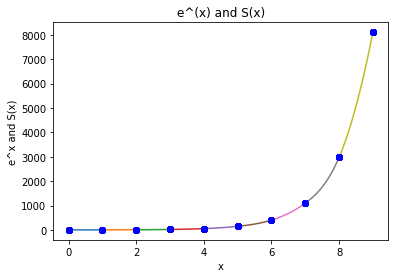

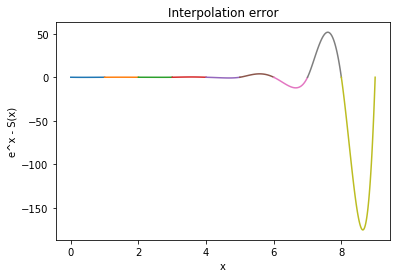

In [19]:
splineplot(df)